In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib.patches as patches 

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns

import cv2

In [2]:
#torch.cuda.empty_cache()

# Config

In [3]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [4]:
class DFireDataset_EVAL(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        # logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        # logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        # logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        # logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        # logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        # logger.info(f'DFire smoke and fire images: {smoke_fire}')
        print(f'DFire total images: {empty+only_smoke+only_fire+smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
        
        img_2_plot = img.copy()
        img_2_plot = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
        
        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                #img = aug['image'] / 255.0
                img = aug['image'] 
            except:
                #print(f'Error trying to augment image {img_file}')
                img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                img = (img / 255.0)
                img = torch.tensor(img, dtype=torch.float32)
                img = img.permute(2, 0, 1)
        
        return img, label, img_2_plot

### View Dataset

In [5]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


# Model: XS Tiny Bed
## XS Ultra Tiny es lo mismo que XS Tiny. Debo haber liado los nombres al pasar del cluster al GPU DIE

In [6]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 64
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 24, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(24, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
#             nn.MaxPool2d(kernel_size=2, stride=2), 
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             # CNNBlock 7x7
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(128, affine=False),
#             nn.ReLU(),
#             nn.Conv2d(128, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(self.last_channels, affine=False),
#             nn.ReLU(),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Evaluate Model

In [7]:
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
    ToTensorV2(p=1),
    ]
)

val_dataset = DFireDataset_EVAL(img_h = IMG_H,
                                img_w = IMG_W,
                                img_dir = val_imgs,
                                label_dir = val_labels,
                                num_classes = N_CLASSES,
                                ds_len=None,
                                transform=val_transform)

# LOADER
BATCH_SIZE = 32
NUM_WORKERS = 1
PIN_MEMORY = True
plot_loader = DataLoader(dataset=val_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         pin_memory=PIN_MEMORY,
                         shuffle=True,
                         drop_last=True)



DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
DFire total images: 4306


In [8]:
view_model = BED_CLASSIFIER(num_classes=N_CLASSES)
model_file = 'xs_ultra_tiny_precision_weighted_save/' + 'best_bed_classifier.pt'

print(model_file)

checkpoint = torch.load(model_file, map_location=torch.device('cpu'))
view_model.load_state_dict(checkpoint['model_state_dict'])

view_model.eval() 

xs_ultra_tiny_precision_weighted_save/best_bed_classifier.pt


BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=

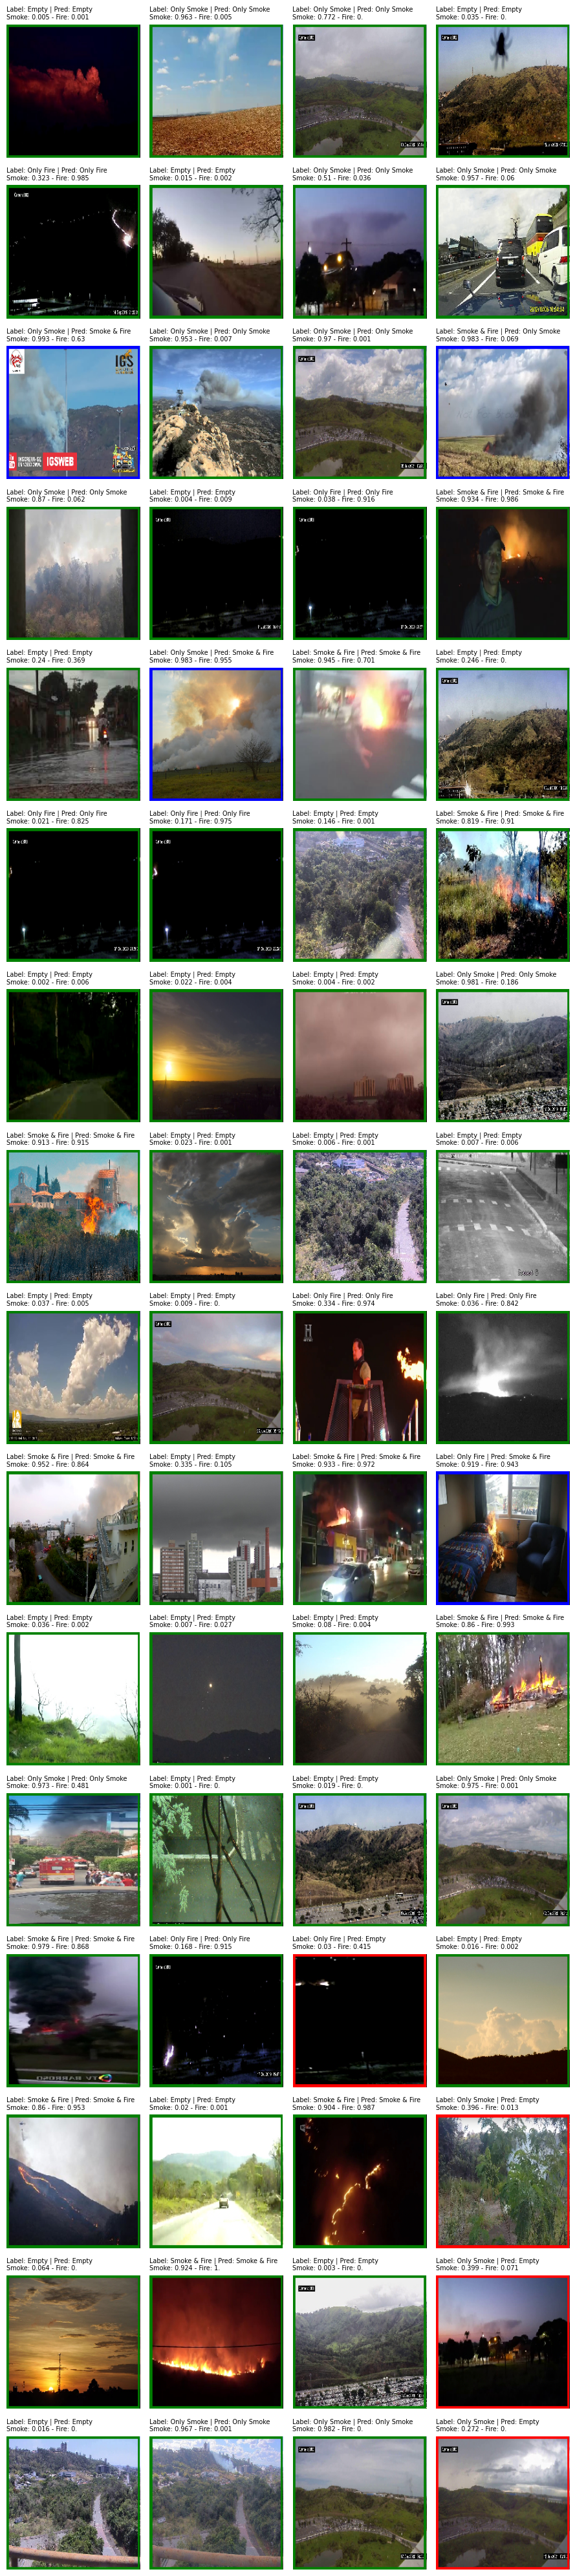

In [9]:
n_imgs_plot = BATCH_SIZE * 2
cols = 4
rows = int( n_imgs_plot / cols )

fig, ax = plt.subplots(rows, cols, figsize=(9, 40)) # BATCH_SIZE*32 -> 320

for batch_idx, (img, label, img_2_plot) in enumerate(plot_loader):
    for i in range(int(BATCH_SIZE/cols)):
        for j in range(cols):

            plot_idx = batch_idx*BATCH_SIZE + i*cols + j + 1
            sample_idx = i*cols + j
            ax_idx = batch_idx*(int(BATCH_SIZE/cols)) + i 
            # print(f'Plot idx: {plot_idx}')
            # print(f'Sample idx: {sample_idx}')
            # print(f'Ax idx: {ax_idx}')
            
            plt.subplot(rows, cols, plot_idx)
            plt.imshow(img_2_plot[sample_idx])

            label_txt = ""
            #print(f'Label: {label[i*cols + j]}')
            if label[sample_idx, 0] == 1 and label[sample_idx, 1] == 1:
                label_txt += "Smoke & Fire"
            elif label[sample_idx, 0] == 1 and label[sample_idx, 1] == 0:
                label_txt += "Only Smoke"
            elif label[sample_idx, 0] == 0 and label[sample_idx, 1] == 1:
                label_txt += "Only Fire"
            else:
                label_txt += "Empty"

            pred = torch.sigmoid( view_model(img[sample_idx].unsqueeze(dim=0)) )
            #print(f'Pred: {pred}')
            pred_txt = ""
            if pred[..., 0] > 0.5 and pred[..., 1] > 0.5:
                pred_txt += "Smoke & Fire"
            elif pred[..., 0] > 0.5 and pred[..., 1] < 0.5:
                pred_txt += "Only Smoke"
            elif pred[..., 0] < 0.5 and pred[..., 1] > 0.5:
                pred_txt += "Only Fire"
            else:
                pred_txt += "Empty"

            if pred_txt == label_txt:
                rect = patches.Rectangle((1, 1), IMG_W-2, IMG_W-3, linewidth=4, edgecolor='g', facecolor="none")
            elif label_txt == "Smoke & Fire" and (pred_txt == "Only Smoke" or pred_txt == "Only Fire"):
                rect = patches.Rectangle((1, 1), IMG_W-2, IMG_W-3, linewidth=4, edgecolor='b', facecolor="none")
            elif label_txt == "Only Smoke" and pred_txt == "Smoke & Fire":
                rect = patches.Rectangle((1, 1), IMG_W-2, IMG_W-3, linewidth=4, edgecolor='b', facecolor="none")
            elif label_txt == "Only Fire" and pred_txt == "Smoke & Fire":
                rect = patches.Rectangle((1, 1), IMG_W-2, IMG_W-3, linewidth=4, edgecolor='b', facecolor="none")
            else:
                rect = patches.Rectangle((1, 1), IMG_W-2, IMG_H-3, linewidth=4, edgecolor='r', facecolor="none")

            ax[ax_idx, j].add_patch(rect)
            ax[ax_idx, j].axis('off')

            title = "Label: " + label_txt + " | " + "Pred: " + pred_txt
            smoke_score = np.round(pred[..., 0].detach().numpy(), 3)
            fire_score = np.round(pred[..., 1].detach().numpy(), 3)
            title += "\n" + "Smoke: " + f'{str(smoke_score)[1:-1]}' + " - Fire: " + f'{str(fire_score)[1:-1]}'
            plt.title(title, fontsize=7, loc='left')

    if (plot_idx == n_imgs_plot):
        plt.tight_layout()
        #plt.savefig("bed_classifier_100K_512pics" + '.png')
        plt.show()
        plt.close()
        break

# METRICS

In [10]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)
smoke_conf_mtx_metric = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5).to(DEVICE)
fire_conf_mtx_metric = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5).to(DEVICE)

### Evaluation Loop

In [56]:
'''
Evaluation Function
'''
def eval_fn(loader, model, device):

    empty = torch.tensor([0, 0], dtype= torch.float32).to(device)
    smoke = torch.tensor([1, 0], dtype= torch.float32).to(device)
    fire = torch.tensor([0, 1], dtype= torch.float32).to(device)
    smoke_fire = torch.tensor([1, 1], dtype= torch.float32).to(device)

    model.to(device)
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)

    y_true = []
    y_pred = []

    for batch_idx, (x, y, _) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
    
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        smoke_conf_mtx_metric.update(yhat[..., 0], y[..., 0])
        fire_conf_mtx_metric.update(yhat[..., 1], y[..., 1])

        yhat = torch.round(yhat)
        for idx in range(out.shape[0]):
            # Predictions: yhat with sigmoid already applied
            if torch.equal(yhat[idx], empty):
                y_pred.append(0)
            elif torch.equal(yhat[idx], smoke):
                y_pred.append(1)
            elif torch.equal(yhat[idx], fire):
                y_pred.append(2)
            elif torch.equal(yhat[idx], smoke_fire):
                y_pred.append(3)
            else:
                print("Wrong Prediction")
                raise SystemExit("Wrong Prediction")
            # Targets
            if torch.equal(y[idx], empty):
                y_true.append(0)
            elif torch.equal(y[idx], smoke):
                y_true.append(1)
            elif torch.equal(y[idx], fire):
                y_true.append(2)
            elif torch.equal(y[idx], smoke_fire):
                y_true.append(3)
            else:
                print("Wrong Target")
                raise SystemExit("Wrong Target")
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    smoke_conf_mtx = smoke_conf_mtx_metric.compute()
    fire_conf_mtx = fire_conf_mtx_metric.compute()

    print("".ljust(6) + "|Accuracy".ljust(10) + "|Precision".ljust(10) + "|Recall".ljust(10) + "|F1".ljust(10))
    print("Smoke".ljust(6) +
          f'|{accuracy[0]:.3f}'.ljust(10) +
          f'|{precision[0]:.3f}'.ljust(10) +
          f'|{recall[0]:.3f}'.ljust(10) +
          f'|{f1[0]:.3f}'.ljust(10))
    print("Fire".ljust(6) +
          f'|{accuracy[1]:.3f}'.ljust(10) +
          f'|{precision[1]:.3f}'.ljust(10) +
          f'|{recall[1]:.3f}'.ljust(10) +
          f'|{f1[1]:.3f}'.ljust(10))
        
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    # smoke_conf_mtx_metric.reset()
    # fire_conf_mtx_metric.reset()
    
    return {'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'y_true': y_true,
            'y_hat': y_pred,
            'smoke_conf_mtx': smoke_conf_mtx,
            'fire_conf_mtx': fire_conf_mtx}

In [57]:
metrics = eval_fn(loader=plot_loader, 
                  model=view_model,
                  device=DEVICE)

Validating: 100%|██████████████████████████████████████████████████████████████| 134/134 [00:16<00:00,  7.93it/s]

      |Accuracy |Precision|Recall   |F1       
Smoke |0.907    |0.908    |0.900    |0.904    
Fire  |0.961    |0.911    |0.942    |0.926    


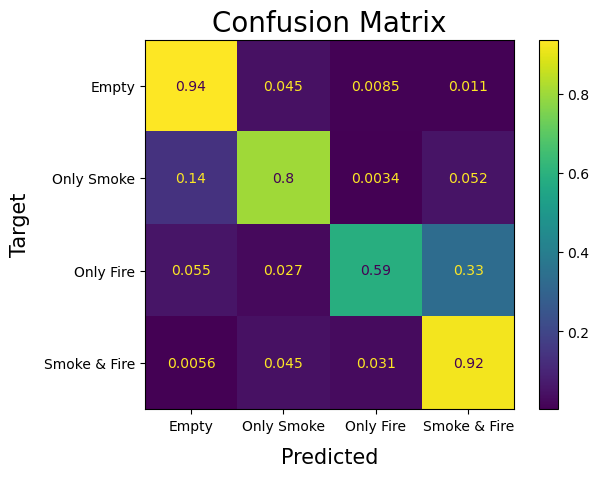

In [14]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_true=metrics['y_true'], 
                                        y_pred=metrics['y_hat'],
                                        normalize='true',
                                        display_labels=['Empty', 'Only Smoke', 'Only Fire', 'Smoke & Fire'],
                                        cmap='viridis',
                                        ax=ax)
plt.title("Confusion Matrix", fontsize=20)
ax.set_xlabel("Predicted", fontsize=15, labelpad=10)
ax.set_ylabel("True", fontsize=15,labelpad=10)
#plt.style.use("seaborn-v0_8")
plt.show()

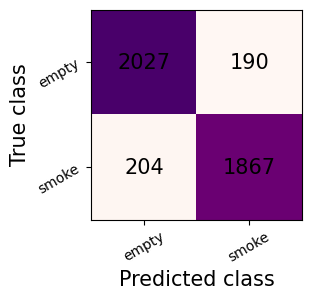

In [15]:
fig, ax = smoke_conf_mtx_metric.plot(cmap='RdPu')
fig.set_size_inches(3,3)
ax.set_xticks(range(2), ['empty', 'smoke'], rotation=30)
ax.set_yticks(range(2), ['empty', 'smoke'], rotation=30)

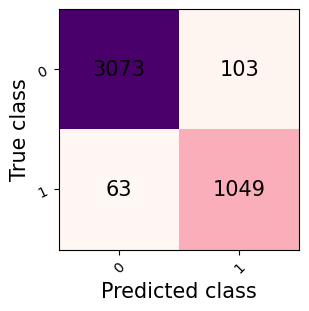

In [16]:
fig, ax = fire_conf_mtx_metric.plot(cmap='RdPu')
fig.set_size_inches(3,3)

# Confusion Matrix with Seaborn

In [25]:
conf_mtx = confusion_matrix(y_true=metrics['y_true'], 
                            y_pred=metrics['y_hat'],
                            normalize='true')
print(type(conf_mtx))
cf_mtx_dic = {
    'Empty': conf_mtx[: , 0],
    'Only Smoke': conf_mtx[:, 1],
    'Only Fire': conf_mtx[:, 2],
    'Smoke & Fire': conf_mtx[:, 3]
}
print(conf_mtx)

<class 'numpy.ndarray'>
[[0.93590386 0.0450676  0.00851277 0.01051577]
 [0.14164546 0.80322307 0.00339271 0.05173876]
 [0.05454545 0.02727273 0.58636364 0.33181818]
 [0.00560538 0.04484305 0.03139013 0.91816143]]


In [22]:
pd_cf_mtx = pd.DataFrame(cf_mtx_dic, index=['Empty', 'Only Smoke', 'Only Fire', 'Smoke & Fire'])

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'Empty'),
  Text(0, 1.5, 'Only Smoke'),
  Text(0, 2.5, 'Only Fire'),
  Text(0, 3.5, 'Smoke & Fire')])

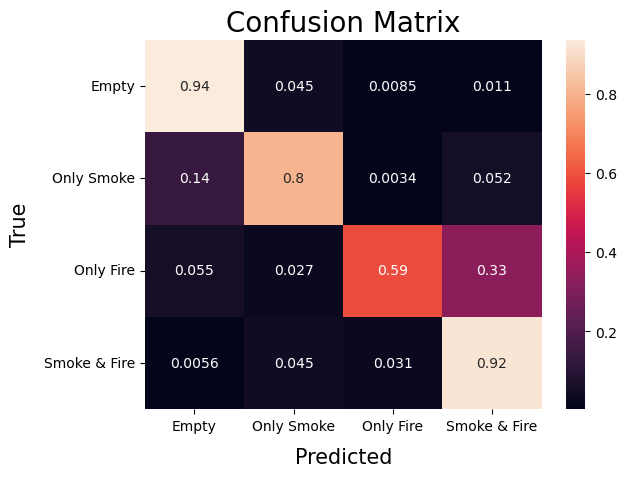

In [30]:
ax = sns.heatmap(pd_cf_mtx, annot=True)
ax.set_title("Confusion Matrix", fontsize=20)
ax.set_xlabel("Predicted", fontsize=15, labelpad=10)
ax.set_ylabel("True", fontsize=15,labelpad=10)
plt.yticks(rotation=0)

In [47]:
metrics_dic = {
    'accuracy': np.round(metrics['accuracy'].cpu().numpy().tolist(), 3),
    'precision': np.round(metrics['precision'].cpu().numpy().tolist(), 3),
    'recall': np.round(metrics['recall'].cpu().numpy().tolist(), 3),
    'f1': np.round(metrics['f1'].cpu().numpy().tolist(), 3)
}
metrics_df = pd.DataFrame(metrics_dic, index=['Smoke', 'Fire'])
metrics_df

accuracy  precision  recall     f1
Smoke     0.908      0.908   0.901  0.905
Fire      0.961      0.911   0.943  0.927